In [1]:
import sys
sys.path.append('../scripts/')
from kf import*

In [2]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0, 0)
        self.cov = np.array([[1,0], [0,2]]) # 共分散行列
        
    def draw(self, ax, elems):
        if self.cov is None: # 共分散行列が設定していなければ描画ストップ
            return
        
        # 推定位置に青の*
        c = ax.scatter(self.pos[0], self.pos[1], s = 100, marker = "*", label = "landmarks", color = "blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id" + str(self.id), fontsize = 10))
        
        # 誤差楕円投入
        e = sigma_ellipse(self.pos, self.cov, 3) # 原点中心のテキトーな共分散行列np.array([[1,0], [0,2]])での楕円
        elems.append(ax.add_patch(e))

In [3]:
class MapParticle(Particle):
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map() # m^_t(i番目) mapを粒子ごとに持たせる
        
        # 粒子にそれぞれマップを持たせる
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark()) # 推定らんどまーく達を全マップへ

In [4]:
class FastSlam(Mcl):
    def __init__(self, envmap, init_pose, particle_num, landmark_num, motion_noise_stds = {"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},\
                distance_dev_rate = 0.14, direction_dev = 0.05):
        super().__init__(envmap, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0 / particle_num, landmark_num) for i in range(particle_num)]# マップ粒子
        self.ml = self.particles[0] # 最重の粒子を新たなリストの先頭へ
        
    def draw(self, ax, elems):
        super().draw(ax, elems) # mclのdraw 粒子の描画（矢印）
        self.ml.map.draw(ax, elems) # EstimatedLandmarkのdraw

<IPython.core.display.Javascript object>


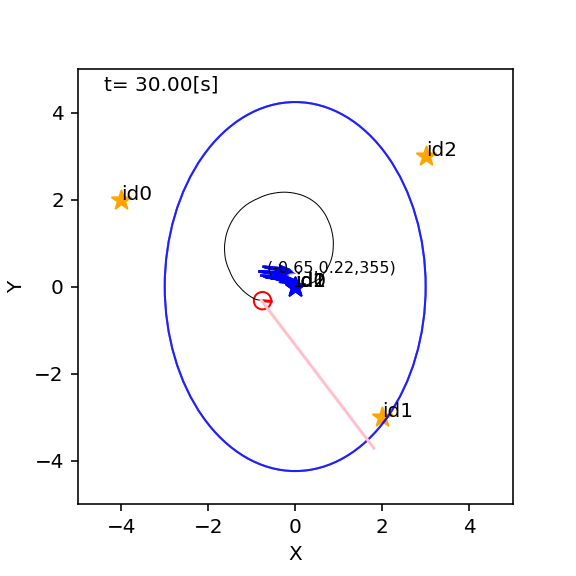

In [6]:
def trial():
    time_interval = 0.1
    world = World(30,time_interval,debug = False)
    
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0,0,0]).T
    pf = FastSlam(m,initial_pose,100, len(m.landmarks)) # 地図, 粒子の数, マップ上のランドマークの数
    a = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,pf)
    r = Robot(initial_pose, sensor = Camera(m), agent = a, color = "red") # このカメラ、ファントム、オクルージョン...全部込み込み
    world.append(r)
    
    world.draw()
    
trial()